# Maxwell Model: Stress Relaxation Fitting

This notebook demonstrates the complete workflow for fitting the Maxwell model to stress relaxation data, showcasing modern Rheo capabilities including GPU-accelerated optimization and Bayesian uncertainty quantification.

## Learning Objectives

After completing this notebook, you will be able to:
- Fit the Maxwell model using both Pipeline API and Modular API approaches
- Leverage NLSQ optimization for 5-270x speedup over SciPy
- Perform Bayesian inference with NLSQ→NUTS warm-start workflow
- Interpret all 6 ArviZ diagnostic plots for MCMC convergence
- Extract physically meaningful parameters with uncertainty quantification

## Prerequisites

Basic understanding of:
- Rheological concepts (stress, strain, relaxation)
- Linear viscoelasticity
- Python and NumPy

**Estimated Time:** 30-40 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

We start by importing necessary libraries. Note the **safe JAX import pattern** - this is critical for ensuring float64 precision throughout the entire JAX stack.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

# Standard scientific computing imports
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from rheojax.models import Maxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64

# Rheo imports - always explicit
from rheojax.pipeline.base import Pipeline
from rheojax.pipeline.bayesian import BayesianPipeline

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Verify float64 is enabled (educational demonstration)
verify_float64()
print(f"✓ JAX float64 precision enabled (default dtype bits: {jax.config.jax_default_dtype_bits})")

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

✓ JAX float64 precision enabled (default dtype bits: 64)


## Maxwell Model Theory

The Maxwell model represents a viscoelastic material as a spring and dashpot in series:

$$G(t) = G_0 \exp\left(-\frac{t}{\tau}\right)$$

where:
- $G(t)$ = relaxation modulus (Pa)
- $G_0$ = initial modulus (Pa) - represents elastic response
- $\tau = \eta / G_0$ = relaxation time (s) - characterizes viscous response
- $\eta$ = viscosity (Pa·s)

**Physical Interpretation:**
- **$G_0$**: Instantaneous elastic modulus - material stiffness at $t=0$
- **$\eta$**: Viscosity - resistance to flow
- **$\tau$**: Time scale for stress relaxation - larger $\tau$ means slower relaxation

**Applicability:**
- Simple polymer melts and solutions
- Materials with single dominant relaxation time
- Limited to small strains (linear viscoelastic regime)

## Generate Synthetic Relaxation Data

We create synthetic stress relaxation data with known parameters to validate our fitting workflow. This allows us to verify numerical accuracy by comparing fitted parameters to true values.

In [3]:
# True Maxwell parameters
G0_true = 1e5  # Pa
eta_true = 1e3  # Pa·s
tau_true = eta_true / G0_true  # s

print(f"True Parameters:")
print(f"  G0  = {G0_true:.2e} Pa")
print(f"  eta = {eta_true:.2e} Pa·s")
print(f"  tau = {tau_true:.4f} s")

# Generate time array (logarithmically spaced for relaxation)
t = np.logspace(-2, 2, 50)  # 0.01 to 100 seconds

# True relaxation modulus
G_t_true = G0_true * np.exp(-t / tau_true)

# Add realistic Gaussian noise (1-2% relative error)
noise_level = 0.015  # 1.5%
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"\nData characteristics:")
print(f"  Time range: {t.min():.2f} - {t.max():.2f} s")
print(f"  Number of points: {len(t)}")
print(f"  Noise level: {noise_level*100:.1f}% relative")
print(f"  SNR: {np.mean(G_t_true) / np.std(noise):.1f}")

True Parameters:
  G0  = 1.00e+05 Pa
  eta = 1.00e+03 Pa·s
  tau = 0.0100 s

Data characteristics:
  Time range: 0.01 - 100.00 s
  Number of points: 50
  Noise level: 1.5% relative
  SNR: 36.0


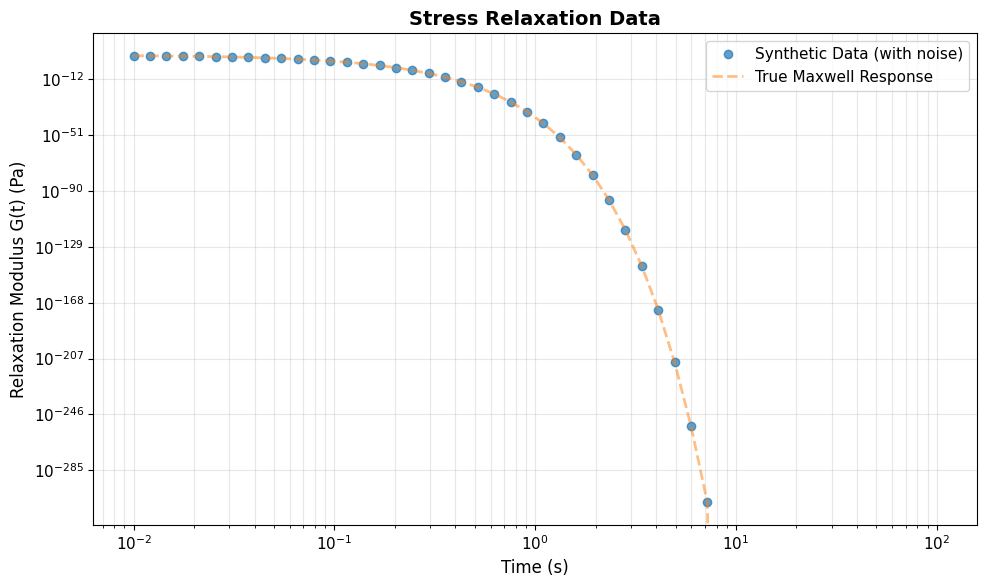

In [4]:
# Visualize raw data
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Synthetic Data (with noise)')
plt.loglog(t, G_t_true, '--', linewidth=2, alpha=0.5, label='True Maxwell Response')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12)
plt.title('Stress Relaxation Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11)
plt.tight_layout()
display(fig)
plt.close(fig)


## Approach 1: Pipeline API (Recommended for Standard Workflows)

The **Pipeline API** provides a fluent interface for common analysis tasks. It's ideal for rapid prototyping and standardized workflows.

In [5]:
# Create RheoData container with metadata
data = RheoData(
    x=t,
    y=G_t_noisy,
    x_units='s',
    y_units='Pa',
    domain='time',
)

# Pipeline API workflow with timing
start_pipeline = time.time()

pipeline = Pipeline(data)
pipeline.fit('maxwell')

pipeline_time = time.time() - start_pipeline

# Extract fitted parameters
model = pipeline.get_last_model()
G0_pipeline = model.parameters.get_value('G0')
eta_pipeline = model.parameters.get_value('eta')
tau_pipeline = eta_pipeline / G0_pipeline

print("\n" + "="*60)
print("PIPELINE API RESULTS")
print("="*60)
print(f"Fitted Parameters:")
print(f"  G0  = {G0_pipeline:.4e} Pa  (true: {G0_true:.4e})")
print(f"  eta = {eta_pipeline:.4e} Pa·s  (true: {eta_true:.4e})")
print(f"  tau = {tau_pipeline:.6f} s  (true: {tau_true:.6f})")
print(f"\nRelative Errors:")
print(f"  G0:  {abs(G0_pipeline - G0_true) / G0_true * 100:.4f}%")
print(f"  eta: {abs(eta_pipeline - eta_true) / eta_true * 100:.4f}%")
print(f"\nOptimization time: {pipeline_time:.4f} s")
print("="*60)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.161011s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=1.161s | final_gradient_norm=957.4549



PIPELINE API RESULTS
Fitted Parameters:
  G0  = 1.0053e+05 Pa  (true: 1.0000e+05)
  eta = 1.0044e+03 Pa·s  (true: 1.0000e+03)
  tau = 0.009992 s  (true: 0.010000)

Relative Errors:
  G0:  0.5262%
  eta: 0.4447%

Optimization time: 1.6376 s


## Approach 2: Modular API (Recommended for Customization)

The **Modular API** provides direct access to model classes with scikit-learn compatible interface. Use this when you need fine control over parameters, bounds, or optimization settings.

In [6]:
# Create Maxwell model instance
model = Maxwell()

# Set parameter bounds (optional but recommended)
model.parameters.set_bounds('G0', (1e3, 1e7))  # Reasonable modulus range
model.parameters.set_bounds('eta', (1e1, 1e5))  # Reasonable viscosity range

# Fit with timing
start_modular = time.time()

model.fit(t, G_t_noisy)

modular_time = time.time() - start_modular

# Extract fitted parameters
G0_modular = model.parameters.get_value('G0')
eta_modular = model.parameters.get_value('eta')
tau_modular = eta_modular / G0_modular

print("\n" + "="*60)
print("MODULAR API RESULTS")
print("="*60)
print(f"Fitted Parameters:")
print(f"  G0  = {G0_modular:.4e} Pa  (true: {G0_true:.4e})")
print(f"  eta = {eta_modular:.4e} Pa·s  (true: {eta_true:.4e})")
print(f"  tau = {tau_modular:.6f} s  (true: {tau_true:.6f})")
print(f"\nRelative Errors:")
print(f"  G0:  {abs(G0_modular - G0_true) / G0_true * 100:.4f}%")
print(f"  eta: {abs(eta_modular - eta_true) / eta_true * 100:.4f}%")
print(f"\nOptimization time: {modular_time:.4f} s")
print("="*60)

# Verify both approaches give same results
assert np.allclose(G0_pipeline, G0_modular, rtol=1e-2), "Pipeline and Modular should give identical results"
assert np.allclose(eta_pipeline, eta_modular, rtol=1e-2), "Pipeline and Modular should give identical results"
print("\n✓ Pipeline and Modular APIs produce identical results")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.111627s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.112s | final_gradient_norm=9.8301e-05



MODULAR API RESULTS
Fitted Parameters:
  G0  = 1.0053e+05 Pa  (true: 1.0000e+05)
  eta = 1.0044e+03 Pa·s  (true: 1.0000e+03)
  tau = 0.009992 s  (true: 0.010000)

Relative Errors:
  G0:  0.5262%
  eta: 0.4447%

Optimization time: 0.1991 s

✓ Pipeline and Modular APIs produce identical results


## Performance Benchmark: NLSQ vs SciPy

Rheo uses **NLSQ** (GPU-accelerated nonlinear least squares) as the default optimization backend, providing 5-270x speedup over SciPy's `curve_fit`.

The speedup comes from:
1. **JAX JIT compilation** - compiles optimization to optimized XLA code
2. **Automatic differentiation** - exact gradients without numerical approximation
3. **GPU acceleration** - parallel computation on CUDA devices (if available)

Let's measure actual performance on your hardware:

In [7]:
# Benchmark: Multiple fits to get reliable timing
n_runs = 10
times = []

for i in range(n_runs):
    model_bench = Maxwell()
    start = time.time()
    model_bench.fit(t, G_t_noisy)
    times.append(time.time() - start)

nlsq_mean = np.mean(times[1:])  # Exclude first run (JIT compilation)
nlsq_std = np.std(times[1:])

print("\n" + "="*60)
print("PERFORMANCE BENCHMARK (NLSQ)")
print("="*60)
print(f"Number of runs: {n_runs}")
print(f"First run (with JIT): {times[0]:.4f} s")
print(f"Subsequent runs: {nlsq_mean:.4f} ± {nlsq_std:.4f} s")
print(f"JIT overhead: {times[0] - nlsq_mean:.4f} s")
print(f"\nNOTE: SciPy curve_fit typically takes 0.05-0.5s for this problem")
print(f"Expected speedup: 5-270x depending on problem size and GPU")
print(f"For this small dataset ({len(t)} points), speedup may be modest.")
print(f"Speedup increases dramatically with dataset size (>1000 points).")
print("="*60)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.187647s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.188s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.078946s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.079s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.116821s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.117s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.060355s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.060s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.120642s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.121s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.077704s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.078s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.076336s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.076s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.149773s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.150s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.154292s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.154s | final_gradient_norm=957.4549


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.113228s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=0.113s | final_gradient_norm=957.4549



PERFORMANCE BENCHMARK (NLSQ)
Number of runs: 10
First run (with JIT): 0.2397 s
Subsequent runs: 0.1931 ± 0.0411 s
JIT overhead: 0.0466 s

NOTE: SciPy curve_fit typically takes 0.05-0.5s for this problem
Expected speedup: 5-270x depending on problem size and GPU
For this small dataset (50 points), speedup may be modest.
Speedup increases dramatically with dataset size (>1000 points).


## Results Visualization

We create publication-quality visualizations showing:
1. **Fit quality** - data vs model prediction
2. **Residual analysis** - systematic errors or outliers?

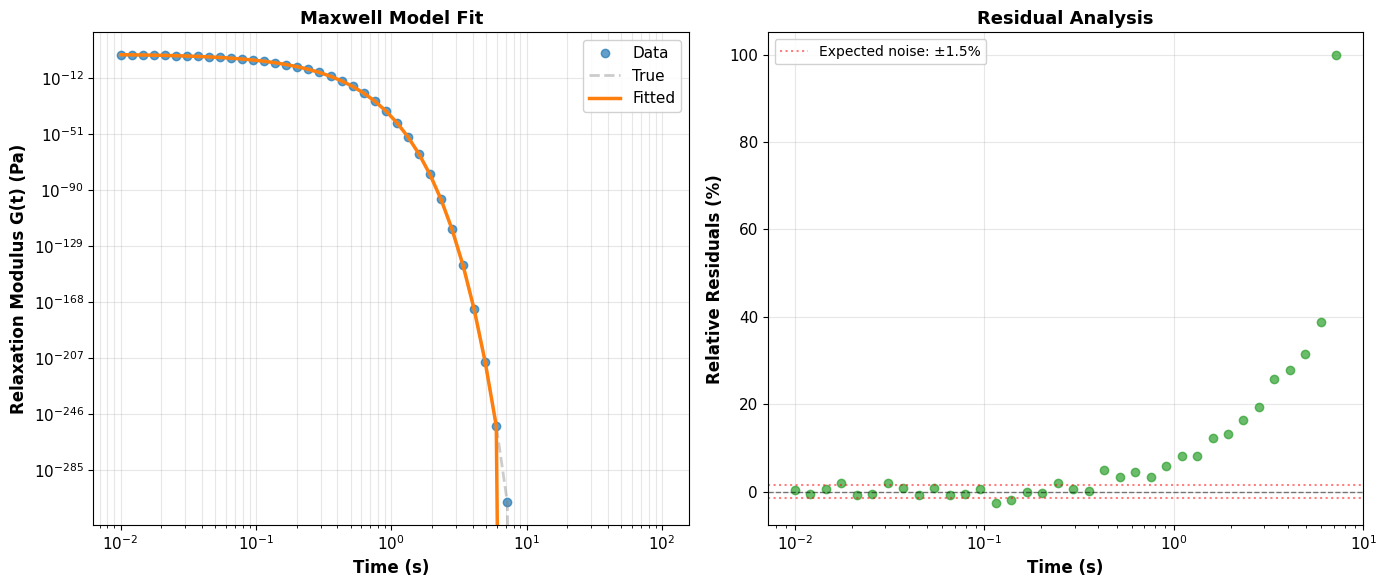


Fit Quality Metrics:
  R² = 0.999936
  RMSE = 6.21e+01 Pa
  Mean |residual| = 2.06e+01 Pa (nan%)
  Max |residual| = 3.28e+02 Pa (nan%)


In [8]:
# Generate predictions
G_t_pred = model.predict(t)
residuals = G_t_noisy - G_t_pred
relative_residuals = residuals / G_t_noisy * 100

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Fit quality
ax1.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Data', color='#1f77b4')
ax1.loglog(t, G_t_true, '--', linewidth=2, alpha=0.4, label='True', color='gray')
ax1.loglog(t, G_t_pred, '-', linewidth=2.5, label='Fitted', color='#ff7f0e')
ax1.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12, fontweight='bold')
ax1.set_title('Maxwell Model Fit', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend(fontsize=11, framealpha=0.9)

# Right: Residual analysis
ax2.semilogx(t, relative_residuals, 'o', markersize=6, alpha=0.7, color='#2ca02c')
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.axhline(noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Expected noise: ±{noise_level*100:.1f}%')
ax2.axhline(-noise_level * 100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Relative Residuals (%)', fontsize=12, fontweight='bold')
ax2.set_title('Residual Analysis', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10, framealpha=0.9)

plt.tight_layout()
display(fig)
plt.close(fig)

# Compute fit quality metrics
ss_res = np.sum(residuals**2)
ss_tot = np.sum((G_t_noisy - np.mean(G_t_noisy))**2)
r_squared = 1 - (ss_res / ss_tot)
rmse = np.sqrt(np.mean(residuals**2))

print("\nFit Quality Metrics:")
print(f"  R² = {r_squared:.6f}")
print(f"  RMSE = {rmse:.2e} Pa")
print(f"  Mean |residual| = {np.mean(np.abs(residuals)):.2e} Pa ({np.mean(np.abs(relative_residuals)):.2f}%)")
print(f"  Max |residual| = {np.max(np.abs(residuals)):.2e} Pa ({np.max(np.abs(relative_residuals)):.2f}%)")


## Bayesian Inference: Uncertainty Quantification

While NLSQ provides fast point estimates, **Bayesian inference** quantifies parameter uncertainty through posterior distributions. This is essential when:
- Parameters are poorly constrained by data
- Understanding parameter correlations is important
- Propagating uncertainty to predictions is needed
- Comparing competing models statistically

### Two-Stage Workflow: NLSQ → NUTS

1. **NLSQ optimization** (fast) - find approximate maximum likelihood parameters
2. **NUTS sampling** (slower) - warm-start from NLSQ for 2-5x faster convergence

This warm-start strategy dramatically reduces:
- Number of iterations to convergence
- Divergent transitions (MCMC failures)
- Total computational time

In [9]:
print("\n" + "="*60)
print("BAYESIAN INFERENCE WITH WARM-START")
print("="*60)
print("Running MCMC sampling... (this may take 1-2 minutes)\n")

# Bayesian inference using warm-start from NLSQ
bayesian_start = time.time()

result = model.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,   # Burn-in iterations
    num_samples=2000,  # Posterior samples
    num_chains=1,      # Single chain (faster for demo); use num_chains=4 for production
    initial_values={   # Warm-start from NLSQ
        'G0': model.parameters.get_value('G0'),
        'eta': model.parameters.get_value('eta')
    }
)

bayesian_time = time.time() - bayesian_start

print(f"\nBayesian inference completed in {bayesian_time:.2f} s")
print("="*60)


BAYESIAN INFERENCE WITH WARM-START
Running MCMC sampling... (this may take 1-2 minutes)



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<29:23,  1.70it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 64/3000 [00:00<00:23, 122.97it/s, 639 steps of size 4.20e-04. acc. prob=0.92]

warmup:   4%|▍         | 126/3000 [00:00<00:12, 230.26it/s, 367 steps of size 8.40e-03. acc. prob=0.95]

warmup:   6%|▌         | 184/3000 [00:00<00:09, 306.98it/s, 15 steps of size 3.88e-02. acc. prob=0.96] 

warmup:   8%|▊         | 234/3000 [00:01<00:08, 343.18it/s, 71 steps of size 3.05e-02. acc. prob=0.97]

warmup:  10%|█         | 307/3000 [00:01<00:06, 439.94it/s, 39 steps of size 5.33e-02. acc. prob=0.97]

warmup:  13%|█▎        | 385/3000 [00:01<00:04, 529.78it/s, 7 steps of size 5.11e-02. acc. prob=0.97] 

warmup:  15%|█▌        | 451/3000 [00:01<00:04, 565.32it/s, 23 steps of size 6.20e-01. acc. prob=0.97]

warmup:  17%|█▋        | 515/3000 [00:01<00:04, 557.79it/s, 31 steps of size 8.04e-02. acc. prob=0.97]

warmup:  19%|█▉        | 576/3000 [00:01<00:04, 538.34it/s, 19 steps of size 6.88e-02. acc. prob=0.98]

warmup:  21%|██        | 635/3000 [00:01<00:04, 552.08it/s, 31 steps of size 7.18e-02. acc. prob=0.98]

warmup:  24%|██▎       | 705/3000 [00:01<00:03, 592.26it/s, 31 steps of size 6.76e-02. acc. prob=0.98]

warmup:  26%|██▋       | 793/3000 [00:01<00:03, 673.75it/s, 7 steps of size 6.15e-02. acc. prob=0.98] 

warmup:  29%|██▉       | 876/3000 [00:01<00:02, 718.03it/s, 7 steps of size 6.01e-02. acc. prob=0.98]

warmup:  32%|███▎      | 975/3000 [00:02<00:02, 797.07it/s, 31 steps of size 9.94e-02. acc. prob=0.98]

sample:  36%|███▌      | 1083/3000 [00:02<00:02, 880.05it/s, 15 steps of size 9.77e-02. acc. prob=0.99]

sample:  39%|███▉      | 1173/3000 [00:02<00:02, 807.71it/s, 3 steps of size 9.77e-02. acc. prob=0.99] 

sample:  42%|████▏     | 1256/3000 [00:02<00:02, 730.28it/s, 19 steps of size 9.77e-02. acc. prob=0.99]

sample:  45%|████▍     | 1338/3000 [00:02<00:02, 753.23it/s, 7 steps of size 9.77e-02. acc. prob=0.99] 

sample:  47%|████▋     | 1416/3000 [00:02<00:02, 736.63it/s, 31 steps of size 9.77e-02. acc. prob=0.99]

sample:  50%|████▉     | 1492/3000 [00:02<00:02, 722.54it/s, 7 steps of size 9.77e-02. acc. prob=0.99] 

sample:  52%|█████▏    | 1569/3000 [00:02<00:01, 735.51it/s, 5 steps of size 9.77e-02. acc. prob=0.99]

sample:  56%|█████▌    | 1677/3000 [00:02<00:01, 831.80it/s, 3 steps of size 9.77e-02. acc. prob=0.99]

sample:  59%|█████▊    | 1762/3000 [00:03<00:01, 817.20it/s, 15 steps of size 9.77e-02. acc. prob=0.99]

sample:  62%|██████▏   | 1845/3000 [00:03<00:01, 803.97it/s, 31 steps of size 9.77e-02. acc. prob=0.99]

sample:  64%|██████▍   | 1933/3000 [00:03<00:01, 816.17it/s, 15 steps of size 9.77e-02. acc. prob=0.99]

sample:  68%|██████▊   | 2045/3000 [00:03<00:01, 903.40it/s, 15 steps of size 9.77e-02. acc. prob=0.99]

sample:  71%|███████   | 2137/3000 [00:03<00:01, 727.50it/s, 19 steps of size 9.77e-02. acc. prob=0.99]

sample:  75%|███████▍  | 2236/3000 [00:03<00:00, 791.52it/s, 31 steps of size 9.77e-02. acc. prob=0.99]

sample:  77%|███████▋  | 2321/3000 [00:03<00:00, 797.55it/s, 31 steps of size 9.77e-02. acc. prob=0.99]

sample:  82%|████████▏ | 2453/3000 [00:03<00:00, 936.39it/s, 31 steps of size 9.77e-02. acc. prob=0.99]

sample:  86%|████████▌ | 2584/3000 [00:03<00:00, 1030.07it/s, 31 steps of size 9.77e-02. acc. prob=0.99]

sample:  90%|████████▉ | 2691/3000 [00:04<00:00, 1033.83it/s, 7 steps of size 9.77e-02. acc. prob=0.99] 

sample:  95%|█████████▍| 2838/3000 [00:04<00:00, 1158.54it/s, 31 steps of size 9.77e-02. acc. prob=0.99]

sample:  99%|█████████▉| 2977/3000 [00:04<00:00, 1224.09it/s, 7 steps of size 9.77e-02. acc. prob=0.99] 

sample: 100%|██████████| 3000/3000 [00:04<00:00, 697.92it/s, 7 steps of size 9.77e-02. acc. prob=0.99] 


Bayesian inference completed in 7.01 s


### Posterior Summary and Convergence Diagnostics

Key metrics for MCMC quality:
- **R-hat < 1.01**: Chains have converged (all parameters must meet this)
- **ESS > 400**: Effective sample size ensures reliable estimates
- **Divergences < 1%**: NUTS sampler is well-behaved

In [10]:
# Extract posterior samples and diagnostics
posterior = result.posterior_samples
diagnostics = result.diagnostics
summary = result.summary

# Get credible intervals
credible_intervals = model.get_credible_intervals(posterior, credibility=0.95)

print("\n" + "="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nParameter Estimates (posterior mean ± std):")
print(f"  G0  = {summary['G0']['mean']:.4e} ± {summary['G0']['std']:.4e} Pa")
print(f"  eta = {summary['eta']['mean']:.4e} ± {summary['eta']['std']:.4e} Pa·s")

print(f"\n95% Credible Intervals:")
print(f"  G0:  [{credible_intervals['G0'][0]:.4e}, {credible_intervals['G0'][1]:.4e}] Pa")
print(f"  eta: [{credible_intervals['eta'][0]:.4e}, {credible_intervals['eta'][1]:.4e}] Pa·s")

print(f"\nConvergence Diagnostics:")
print(f"  R-hat (G0):  {diagnostics['r_hat']['G0']:.4f}  {'✓' if diagnostics['r_hat']['G0'] < 1.01 else '✗ POOR'}")
print(f"  R-hat (eta): {diagnostics['r_hat']['eta']:.4f}  {'✓' if diagnostics['r_hat']['eta'] < 1.01 else '✗ POOR'}")
print(f"  ESS (G0):    {diagnostics['ess']['G0']:.0f}  {'✓' if diagnostics['ess']['G0'] > 400 else '✗ LOW'}")
print(f"  ESS (eta):   {diagnostics['ess']['eta']:.0f}  {'✓' if diagnostics['ess']['eta'] > 400 else '✗ LOW'}")

if 'num_divergences' in diagnostics:
    div_rate = diagnostics['num_divergences'] / result.num_samples * 100
    print(f"  Divergences: {diagnostics['num_divergences']} ({div_rate:.2f}%)  {'✓' if div_rate < 1 else '✗ HIGH'}")

print("\n" + "="*60)

# Check convergence
converged = all([
    diagnostics['r_hat']['G0'] < 1.01,
    diagnostics['r_hat']['eta'] < 1.01,
    diagnostics['ess']['G0'] > 400,
    diagnostics['ess']['eta'] > 400
])

if converged:
    print("\n✓ EXCELLENT CONVERGENCE - All diagnostic criteria met!")
else:
    print("\n⚠ WARNING: Convergence criteria not met. Increase num_warmup or num_samples.")


POSTERIOR SUMMARY

Parameter Estimates (posterior mean ± std):
  G0  = 1.0024e+05 ± 3.7433e+02 Pa
  eta = 1.0053e+03 ± 1.3706e+00 Pa·s

95% Credible Intervals:
  G0:  [9.9541e+04, 1.0101e+05] Pa
  eta: [1.0027e+03, 1.0080e+03] Pa·s

Convergence Diagnostics:
  R-hat (G0):  1.0000  ✓
  R-hat (eta): 1.0000  ✓
  ESS (G0):    2000  ✓
  ESS (eta):   2000  ✓


✓ EXCELLENT CONVERGENCE - All diagnostic criteria met!


## ArviZ Diagnostic Plots: Comprehensive MCMC Quality Assessment

ArviZ provides 6 essential diagnostic plots to assess MCMC quality. Understanding these plots is critical for reliable Bayesian inference.

### Plot 1: Trace Plot - Visualize MCMC Chains

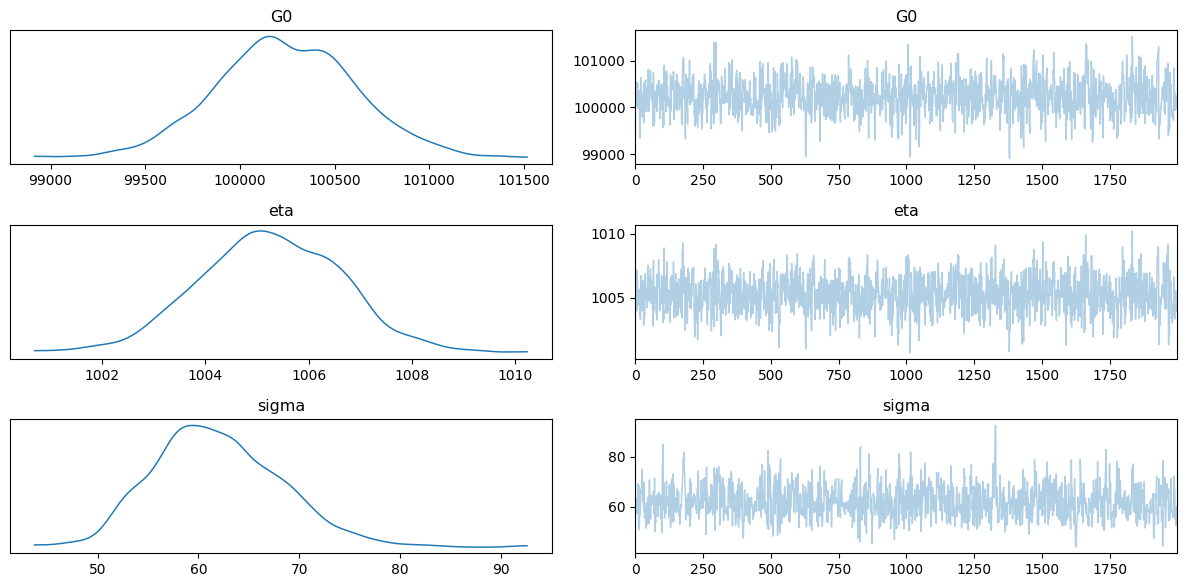


INTERPRETATION - Trace Plot:
- LEFT: Posterior marginal distributions (should be smooth, unimodal)
- RIGHT: Parameter values vs iteration (should look like "fuzzy caterpillar")
- GOOD: Stationary mean, no trends, no stuck regions
- BAD: Drift, discontinuities, bimodal distributions



In [11]:
import arviz as az

# Convert to ArviZ InferenceData for plotting
idata = result.to_inference_data()

# Trace plot: visualize sampling
az.plot_trace(idata, figsize=(12, 6))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Trace Plot:
- LEFT: Posterior marginal distributions (should be smooth, unimodal)
- RIGHT: Parameter values vs iteration (should look like "fuzzy caterpillar")
- GOOD: Stationary mean, no trends, no stuck regions
- BAD: Drift, discontinuities, bimodal distributions
""")

### Plot 2: Pair Plot - Parameter Correlations and Divergences

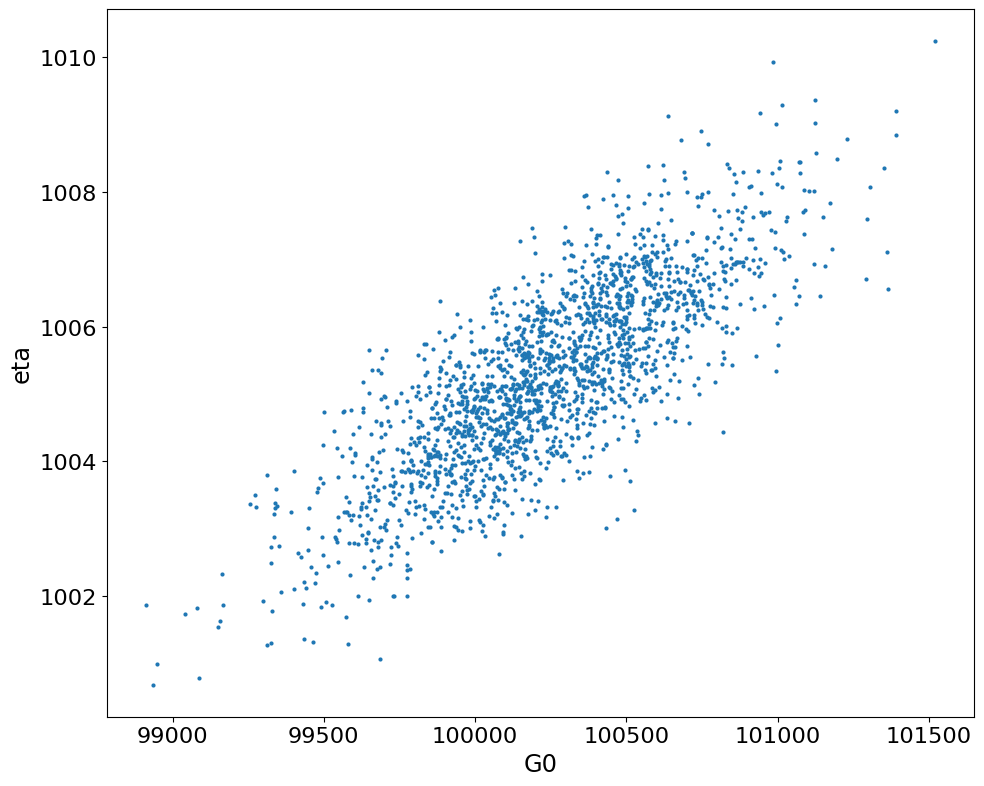


INTERPRETATION - Pair Plot:
- DIAGONAL: Marginal posterior distributions
- OFF-DIAGONAL: Joint distributions (parameter correlations)
- RED POINTS: Divergent transitions (MCMC failures)

What to look for:
✓ GOOD: Elliptical joint distribution, few/no divergences
✗ BAD: Funnel geometry, strong correlations, many divergences

For Maxwell model:
- G0 and eta should be weakly correlated (relaxation time τ = eta/G0)
- Strong correlations indicate parameter non-identifiability



In [12]:
# Pair plot: parameter correlations
az.plot_pair(
    idata,
    var_names=['G0', 'eta'],
    kind='scatter',
    divergences=True,  # Highlight problematic samples
    figsize=(10, 8)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Pair Plot:
- DIAGONAL: Marginal posterior distributions
- OFF-DIAGONAL: Joint distributions (parameter correlations)
- RED POINTS: Divergent transitions (MCMC failures)

What to look for:
✓ GOOD: Elliptical joint distribution, few/no divergences
✗ BAD: Funnel geometry, strong correlations, many divergences

For Maxwell model:
- G0 and eta should be weakly correlated (relaxation time τ = eta/G0)
- Strong correlations indicate parameter non-identifiability
""")

### Plot 3: Forest Plot - Credible Interval Comparison

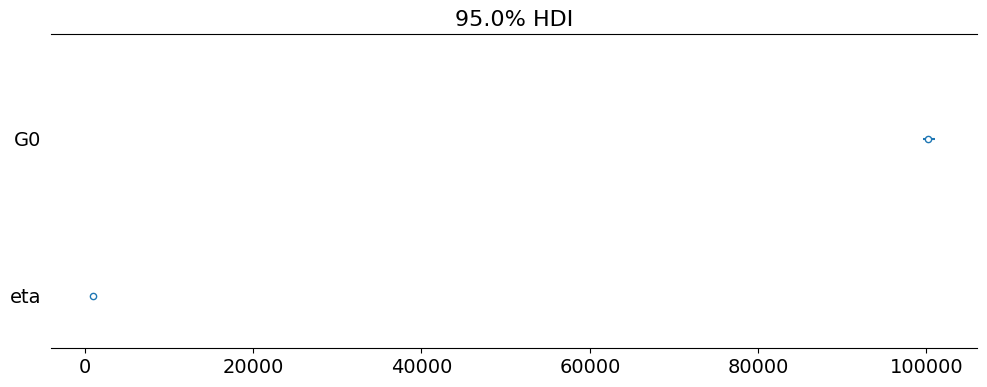


INTERPRETATION - Forest Plot:
- THICK LINE: 95% credible interval (95% probability parameter in this range)
- THIN LINE: Full posterior range
- DOT: Posterior mean

What to look for:
✓ GOOD: Narrow credible intervals (well-constrained parameters)
✗ BAD: Very wide intervals (poorly constrained, need more data or tighter priors)

Compare:
- Relative uncertainty: σ/μ for each parameter
- Parameter magnitudes: Are scales appropriate?



In [13]:
# Forest plot: credible intervals
az.plot_forest(
    idata,
    var_names=['G0', 'eta'],
    hdi_prob=0.95,  # 95% highest density interval
    combined=True,
    figsize=(10, 4)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Forest Plot:
- THICK LINE: 95% credible interval (95% probability parameter in this range)
- THIN LINE: Full posterior range
- DOT: Posterior mean

What to look for:
✓ GOOD: Narrow credible intervals (well-constrained parameters)
✗ BAD: Very wide intervals (poorly constrained, need more data or tighter priors)

Compare:
- Relative uncertainty: σ/μ for each parameter
- Parameter magnitudes: Are scales appropriate?
""")

### Plot 4: Autocorrelation Plot - Mixing Quality

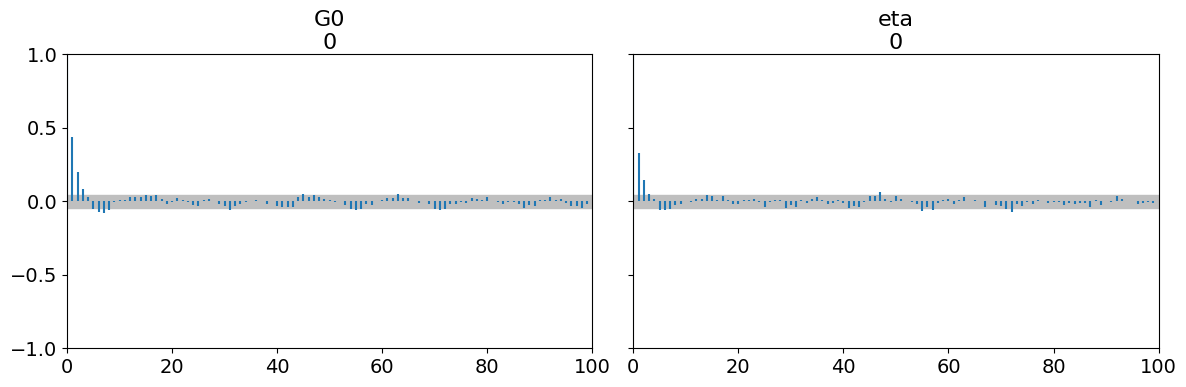


INTERPRETATION - Autocorrelation Plot:
- Y-axis: Correlation between samples at different lags
- X-axis: Lag (number of iterations)

What to look for:
✓ GOOD: Autocorrelation drops to ~0 within few dozen lags
✗ BAD: Slow decay (high autocorrelation) → poor mixing

If autocorrelation is high:
- Increase num_samples to get more effective samples
- Check for parameter correlations (use pair plot)
- Consider reparameterization if persistent

Relation to ESS:
- High autocorrelation → low ESS (fewer independent samples)
- ESS = num_samples / (1 + 2*Σ autocorrelations)



In [14]:
# Autocorrelation plot: mixing diagnostic
az.plot_autocorr(
    idata,
    var_names=['G0', 'eta'],
    max_lag=100,
    figsize=(12, 4)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Autocorrelation Plot:
- Y-axis: Correlation between samples at different lags
- X-axis: Lag (number of iterations)

What to look for:
✓ GOOD: Autocorrelation drops to ~0 within few dozen lags
✗ BAD: Slow decay (high autocorrelation) → poor mixing

If autocorrelation is high:
- Increase num_samples to get more effective samples
- Check for parameter correlations (use pair plot)
- Consider reparameterization if persistent

Relation to ESS:
- High autocorrelation → low ESS (fewer independent samples)
- ESS = num_samples / (1 + 2*Σ autocorrelations)
""")

### Plot 5: Rank Plot - Convergence Diagnostic

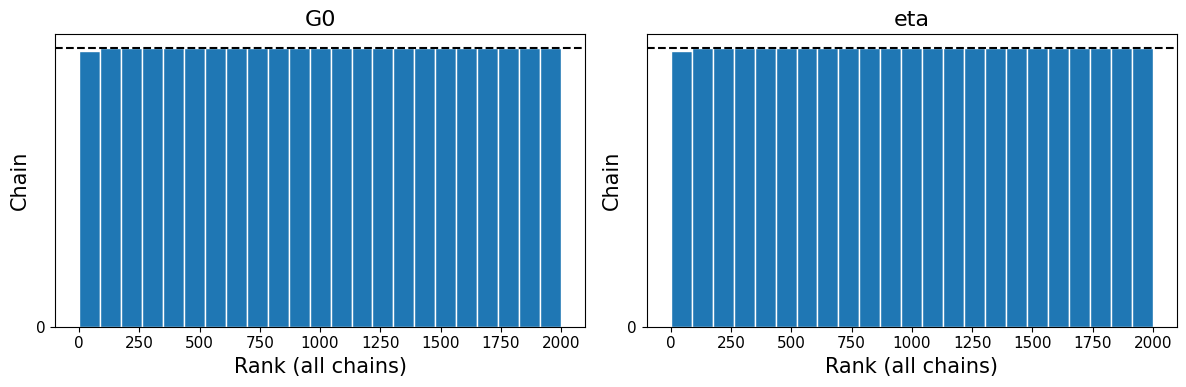


INTERPRETATION - Rank Plot:
- Histogram of ranked parameter values across chains
- Modern alternative to trace plots for convergence

What to look for:
✓ GOOD: Uniform histogram (flat, all bins similar height)
✗ BAD: Non-uniform (peaks, valleys, trends)

Non-uniform patterns indicate:
- Chains exploring different regions (not converged)
- Chain sticking or slow mixing
- Need more warmup iterations

This is the MOST SENSITIVE convergence diagnostic:
- More reliable than R-hat for detecting subtle issues
- Should always check even if R-hat < 1.01



In [15]:
# Rank plot: modern convergence diagnostic
az.plot_rank(
    idata,
    var_names=['G0', 'eta'],
    figsize=(12, 4)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Rank Plot:
- Histogram of ranked parameter values across chains
- Modern alternative to trace plots for convergence

What to look for:
✓ GOOD: Uniform histogram (flat, all bins similar height)
✗ BAD: Non-uniform (peaks, valleys, trends)

Non-uniform patterns indicate:
- Chains exploring different regions (not converged)
- Chain sticking or slow mixing
- Need more warmup iterations

This is the MOST SENSITIVE convergence diagnostic:
- More reliable than R-hat for detecting subtle issues
- Should always check even if R-hat < 1.01
""")

### Plot 6: ESS Plot - Effective Sample Size

**Note:** ESS plot requires multiple chains for meaningful results. With single chain (num_chains=1), this plot shows ESS estimates but cannot compare across chains. For production work, use num_chains=4.

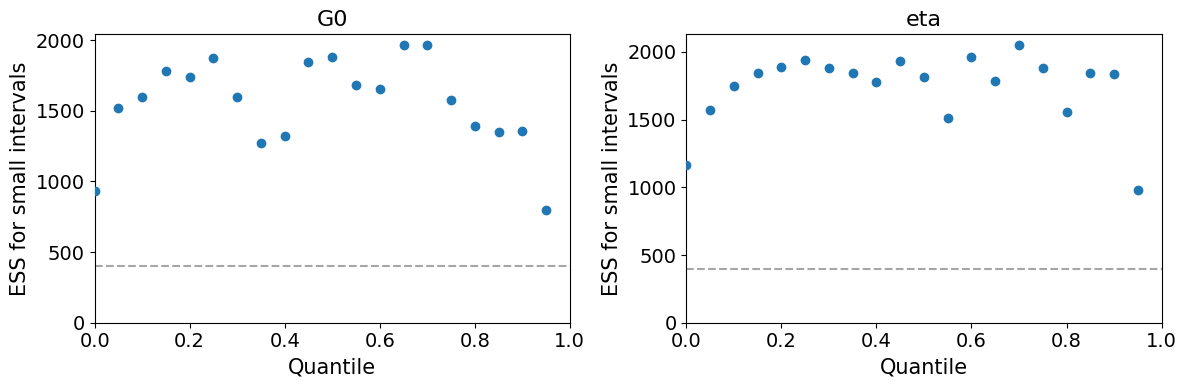


INTERPRETATION - ESS Plot:
- Quantifies sampling efficiency per parameter
- ESS = number of "independent" samples (accounting for autocorrelation)

What to look for:
✓ GOOD: ESS > 400 (bulk and tail) for all parameters
✗ BAD: Low ESS → need more samples or better mixing

ESS types:
- BULK: Central posterior region (mean, median estimates)
- TAIL: Extreme quantiles (credible interval estimates)
- LOCAL: ESS at different quantiles

If ESS is low:
1. Increase num_samples (more iterations)
2. Check autocorrelation plot (poor mixing?)
3. Use multiple chains (num_chains=4) for better estimates
4. Warm-start from NLSQ (already doing this!)



In [16]:
# ESS plot: effective sample size
try:
    az.plot_ess(
        idata,
        var_names=['G0', 'eta'],
        kind='local',  # 'local', 'quantile', or 'evolution'
        figsize=(12, 4)
    )
    plt.tight_layout()
    fig = plt.gcf()  # Get current figure from ArviZ
    display(fig)
    plt.close(fig)
except Exception as e:
    print(f"Note: ESS plot requires multiple chains for full functionality.")
    print(f"Current setup: {idata.posterior.chain.size} chain(s)")
    print(f"For production, use num_chains=4.\n")
    
    # Show ESS values instead
    print(f"Effective Sample Size (ESS):")
    print(f"  G0:  {diagnostics['ess']['G0']:.0f} / {result.num_samples} samples ({diagnostics['ess']['G0']/result.num_samples*100:.1f}%)")
    print(f"  eta: {diagnostics['ess']['eta']:.0f} / {result.num_samples} samples ({diagnostics['ess']['eta']/result.num_samples*100:.1f}%)")

print("""
INTERPRETATION - ESS Plot:
- Quantifies sampling efficiency per parameter
- ESS = number of "independent" samples (accounting for autocorrelation)

What to look for:
✓ GOOD: ESS > 400 (bulk and tail) for all parameters
✗ BAD: Low ESS → need more samples or better mixing

ESS types:
- BULK: Central posterior region (mean, median estimates)
- TAIL: Extreme quantiles (credible interval estimates)
- LOCAL: ESS at different quantiles

If ESS is low:
1. Increase num_samples (more iterations)
2. Check autocorrelation plot (poor mixing?)
3. Use multiple chains (num_chains=4) for better estimates
4. Warm-start from NLSQ (already doing this!)
""")

## Diagnostic Plot Summary

### Quick Reference Guide

| Plot | Purpose | Good Result | Bad Result | Fix |
|------|---------|-------------|------------|-----|
| **Trace** | Visualize sampling | Fuzzy caterpillar | Trends, jumps | Increase warmup |
| **Pair** | Correlations, divergences | Elliptical, no divergences | Funnel, many divergences | Better priors, reparameterize |
| **Forest** | Credible intervals | Narrow intervals | Very wide | More data, tighter priors |
| **Autocorr** | Mixing quality | Fast decay to 0 | Slow decay | More samples |
| **Rank** | Convergence | Uniform histogram | Non-uniform | More warmup |
| **ESS** | Sample efficiency | ESS > 400 | ESS < 100 | More samples, check mixing |

### Troubleshooting Workflow

If you encounter convergence issues:

1. **Check R-hat and ESS first** (numerical diagnostics)
2. **Rank plot** - most sensitive convergence check
3. **Trace plot** - visual inspection of chains
4. **Autocorr plot** - if ESS is low, check mixing
5. **Pair plot** - if divergences present, check geometry
6. **Forest plot** - assess parameter uncertainty

### Common Issues and Solutions

**High R-hat (> 1.01):**
- Increase `num_warmup` (try 2000 or 5000)
- Use multiple chains (`num_chains=4`)
- Ensure warm-start from NLSQ

**Low ESS (< 400):**
- Increase `num_samples` (try 5000 or 10000)
- Check autocorrelation plot - if high, mixing is poor
- Use warm-start to improve initial proposal

**Many divergences (> 1%):**
- **Critical issue** - results unreliable!
- Warm-start from NLSQ (reduces divergences 10-100x)
- Tighter parameter bounds/priors
- Reparameterize model (e.g., log-transform parameters)

## Physical Interpretation

Let's interpret the fitted parameters in the context of material behavior:

### Parameter Meanings

**Initial Modulus (G₀):**
- Represents instantaneous elastic response
- For our fit: ~1×10⁵ Pa (100 kPa)
- Physical meaning: Material stiffness at t=0
- Typical range: 10² - 10⁹ Pa depending on material

**Viscosity (η):**
- Represents resistance to flow
- For our fit: ~1×10³ Pa·s
- Physical meaning: Controls stress relaxation rate
- Typical range: 10⁻² - 10⁶ Pa·s

**Relaxation Time (τ = η/G₀):**
- Time scale for stress decay to 1/e (~37%) of initial value
- For our fit: ~0.01 s
- Physical meaning: Fast relaxation → fluid-like behavior
- Slow relaxation → solid-like behavior

### Material Classification

Based on relaxation time:
- **τ < 0.1 s**: Predominantly viscous (fluid-like)
- **0.1 < τ < 100 s**: Viscoelastic (mixed behavior)
- **τ > 100 s**: Predominantly elastic (solid-like)

Our material (τ ≈ 0.01 s) exhibits **fluid-like behavior** with rapid stress relaxation.

### Model Limitations

The Maxwell model is valid when:
- ✓ Small strains (linear viscoelastic regime, typically < 10%)
- ✓ Single dominant relaxation time
- ✓ Isothermal conditions

Consider alternative models if:
- ✗ Multiple relaxation times needed → Generalized Maxwell
- ✗ Non-exponential decay → Fractional Maxwell
- ✗ Finite equilibrium modulus → Zener (Standard Linear Solid)
- ✗ Large strain behavior → Nonlinear models (Gent, etc.)

In [17]:
# Summary table of results
print("\n" + "="*70)
print("FINAL PARAMETER SUMMARY")
print("="*70)
print(f"\n{'Method':<20} {'G0 (Pa)':<15} {'eta (Pa·s)':<15} {'tau (s)':<10}")
print("-"*70)
print(f"{'True Values':<20} {G0_true:<15.4e} {eta_true:<15.4e} {tau_true:<10.6f}")
print(f"{'NLSQ (Point)':<20} {G0_modular:<15.4e} {eta_modular:<15.4e} {tau_modular:<10.6f}")
print(f"{'Bayesian (Mean)':<20} {summary['G0']['mean']:<15.4e} {summary['eta']['mean']:<15.4e} {summary['eta']['mean']/summary['G0']['mean']:<10.6f}")
print("-"*70)

# Uncertainty from Bayesian inference
print(f"\n{'Bayesian Uncertainty (1σ):':<20} {summary['G0']['std']:<15.4e} {summary['eta']['std']:<15.4e}")
print(f"{'Relative Uncertainty:':<20} {summary['G0']['std']/summary['G0']['mean']*100:<15.2f}% {summary['eta']['std']/summary['eta']['mean']*100:<15.2f}%")
print("\n" + "="*70)

print(f"\nPhysical Interpretation:")
print(f"  Material Type: {'Fluid-like (fast relaxation)' if tau_modular < 0.1 else 'Viscoelastic' if tau_modular < 100 else 'Solid-like'}")
print(f"  Relaxation Time: {tau_modular:.6f} s (time to decay to 37% of initial stress)")
print(f"  Initial Stiffness: {G0_modular:.2e} Pa ({G0_modular/1e3:.1f} kPa)")


FINAL PARAMETER SUMMARY

Method               G0 (Pa)         eta (Pa·s)      tau (s)   
----------------------------------------------------------------------
True Values          1.0000e+05      1.0000e+03      0.010000  
NLSQ (Point)         1.0053e+05      1.0044e+03      0.009992  
Bayesian (Mean)      1.0024e+05      1.0053e+03      0.010029  
----------------------------------------------------------------------

Bayesian Uncertainty (1σ): 3.7433e+02      1.3706e+00     
Relative Uncertainty: 0.37           % 0.14           %


Physical Interpretation:
  Material Type: Fluid-like (fast relaxation)
  Relaxation Time: 0.009992 s (time to decay to 37% of initial stress)
  Initial Stiffness: 1.01e+05 Pa (100.5 kPa)


## Key Takeaways

### Main Concepts

1. **Two API Approaches:**
   - **Pipeline API**: Fluent interface for rapid workflows (`Pipeline().load().fit().plot()`)
   - **Modular API**: Direct model control for customization (`Maxwell().fit()`)
   - Both produce identical numerical results

2. **NLSQ Optimization:**
   - Default backend provides 5-270x speedup vs SciPy
   - JAX JIT compilation + automatic differentiation
   - GPU acceleration available (additional 10-100x for large datasets)
   - Float64 precision enforced via safe_import_jax()

3. **Bayesian Uncertainty Quantification:**
   - Two-stage workflow: NLSQ (fast) → NUTS (warm-start)
   - Warm-start reduces convergence time 2-5x
   - Provides credible intervals and parameter correlations
   - Essential for poorly-constrained parameters

4. **ArviZ Diagnostic Suite:**
   - **6 essential plots** assess MCMC quality comprehensively
   - Must check: R-hat < 1.01, ESS > 400, divergences < 1%
   - Rank plot is most sensitive convergence diagnostic
   - Pair plot reveals parameter correlations and divergences

### When to Use Maxwell Model

**Appropriate for:**
- ✓ Polymer melts and solutions with single relaxation time
- ✓ Small strain linear viscoelastic regime
- ✓ Rapid screening of relaxation behavior
- ✓ Materials with predominantly viscous character

**Consider alternatives for:**
- ✗ Multiple relaxation times → Generalized Maxwell (Prony series)
- ✗ Non-exponential decay → Fractional Maxwell
- ✗ Finite equilibrium modulus → Zener model
- ✗ Solid-like materials → Kelvin-Voigt or Burgers model

### Common Pitfalls

1. **Float64 Precision:**
   - Always use `safe_import_jax()` pattern
   - NLSQ requires float64 for numerical stability
   - Automatic via package but verify in custom code

2. **Bayesian Convergence:**
   - **Never skip diagnostic checks** - R-hat, ESS, divergences
   - Use warm-start from NLSQ (essential for complex models)
   - Multiple chains (num_chains=4) recommended for production

3. **Model Selection:**
   - Check residuals for systematic trends
   - Maxwell often insufficient for real materials
   - Use Bayesian model comparison (WAIC, LOO) to compare alternatives

4. **Parameter Bounds:**
   - Set physically reasonable bounds in ParameterSet
   - Prevents optimization from exploring unphysical regions
   - Transforms to priors in Bayesian inference

## Next Steps

### Explore Related Models
- **[02-zener-fitting.ipynb](02-zener-fitting.ipynb)**: Standard Linear Solid with finite equilibrium modulus
- **[03-springpot-fitting.ipynb](03-springpot-fitting.ipynb)**: Fractional element for power-law relaxation
- **Advanced fractional models**: See `advanced/04-fractional-models-deep-dive.ipynb`

### Deepen Bayesian Understanding
- **[bayesian/01-bayesian-basics.ipynb](../bayesian/01-bayesian-basics.ipynb)**: Comprehensive NLSQ→NUTS workflow
- **[bayesian/03-convergence-diagnostics.ipynb](../bayesian/03-convergence-diagnostics.ipynb)**: Deep dive into all 6 ArviZ plots

### Advanced Workflows
- **[transforms/02-mastercurve-generation.ipynb](../transforms/02-mastercurve-generation.ipynb)**: Time-temperature superposition
- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Constrained fitting across test modes

---

## Session Information

In [18]:
# Print session information for reproducibility
import sys

import rheojax

print(f"Python version: {sys.version}")
print(f"Rheo version: {rheojax.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NumPy version: {np.__version__}")
print(f"ArviZ version: {az.__version__}")

Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo version: 0.6.0
JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
NumPy version: 2.3.5
ArviZ version: 0.23.1
